# Forecasting Air Pollution in Belgium
After the citizen science project of [Curieuze Neuzen](https://curieuzeneuzen.be/), I wanted to learn more about air pollution and see if I could make a data science project out of it. On the website of the [European Environment Agency](https://www.eea.europa.eu/data-and-maps/data/aqereporting-8) you can find a huge amount of data and information about air pollution. 

In this notebook we will focus on the air quality in **Belgium** and more specific on the pollution by **sulphur dioxide (SO2)**. The data can be downloaded via https://www.eea.europa.eu/data-and-maps/data/aqereporting-2/be. The zip file contains separate files for different air pollutants and aggregation levels. The first digit represents the pollutant ID as described in the [vocabulary](http://dd.eionet.europa.eu/vocabulary/aq/pollutant). The files used in this notebook are:

* BE_1_2013-2015_aggregated_timeseries.csv
* BE_2013-2015_metadata.csv

Descriptions of the fields in the CSV files is available on the [data download page](https://www.eea.europa.eu/data-and-maps/data/aqereporting-2/be.). More background information on air pollutants can also be found on [Wikipedia](https://nl.wikipedia.org/wiki/Luchtvervuiling).

## Project Set-up

In [12]:
# Importing packages
from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

# Setting the project directory
project_dir = Path('/Users/bertcarremans/Data Science/Projecten/air_pollution_forecasting')

## Loading the data

In [52]:
date_vars = ['DatetimeBegin','DatetimeEnd']

agg_ts = pd.read_csv(project_dir / 'data/raw/BE_1_2013-2015_aggregated_timeseries.csv', sep='\t', parse_dates=date_vars, date_parser=pd.to_datetime)
meta = pd.read_csv(project_dir / 'data/raw/BE_2013-2015_metadata.csv', sep='\t')

print('aggregated timeseries shape:{}'.format(agg_ts.shape))
print('metadata shape:{}'.format(meta.shape))

aggregated timeseries shape:(53647, 18)
metadata shape:(1289, 26)


## Data Exploration

Let's use **pandas_profiling** to inspect the data. The pandas_profiling report learns us the following:

* There are 6 constant variables. We can remove these from the data set.
* No missing values exist, so probably we will not need to apply imputation.
* **AirPollutionLevel** has some zeroes, but this could be perfectly normal. On the other hand, this variables has some extreme values, which might be incorrect recordings of the air pollution.
* There are 53 **AirQualityStations**, which are probably the same as the **SamplingPoints**. **AirQualityStationEoICode** is simply an shorter code for the AirQualityStation, so that variable can also be removed.
* There are 3 values for **AirQualityNetwork** (Brussels, Flanders and Wallonia). Most measurements come from Flanders.
* **DataAggregationProcess**: most rows contain data aggregated as the 24-hour mean of one day of measurements (P1D). More information on the other values can be found [here](http://dd.eionet.europa.eu/vocabulary/aq/aggregationprocess). In this project we will only consider P1D values.
* **DataCapture**: Proportion of valid measurement time relative to the total measured time (time coverage) in the averaging period, expressed as percentage. Almost all rows have about 100% of valid measurement time. Some rows have a DataCapture that is slightly lower than 100%.
* **DataCoverage**: Proportion of valid measurement included in the aggregation process within the averaging period, expressed as percentage. In this data set we have a minimum of 75%. According to the [definition of this variable](https://www.eea.europa.eu/data-and-maps/data/aqereporting-2/be) values below 75% should not be included for air quality assessments, which explains why these rows are not present in the data set. 
* **TimeCoverage**: highly correlated to DataCoverage and will be removed from the data.
* **UnitOfAirPollutionLevel**: 423 rows have a unit of *count*. To have a consistent target variable we will remove the records with this type of unit.
* **DateTimeBegin** and **DateTimeEnd**: the histogram does not provide enough detail here. This needs to be analyzed further.



In [3]:
pandas_profiling.ProfileReport(agg_ts)

Number of variables,18
Number of observations,53647
Total Missing (%),0.0%
Total size in memory,7.4 MiB
Average record size in memory,144.0 B
Numeric,3
Categorical,6
Boolean,0
Date,2
Text (Unique),0
Rejected,7


### DateTimeBegin and DateTimeEnd
The histogram in the pandas_profiling combined multiple days per bin. Let's look at a daily level how these variables behave.

#### Multiple aggregation levels per date
* **DatetimeBegin**: large number of records on the 1st of January of 2013, 2014, 2015 and 1st of October of 2013 and 2014.
* **DatetimeEnd**: large number of records on the 1st of January of 2014, 2015, 2016 and 1st of April of 2014 and 2015.

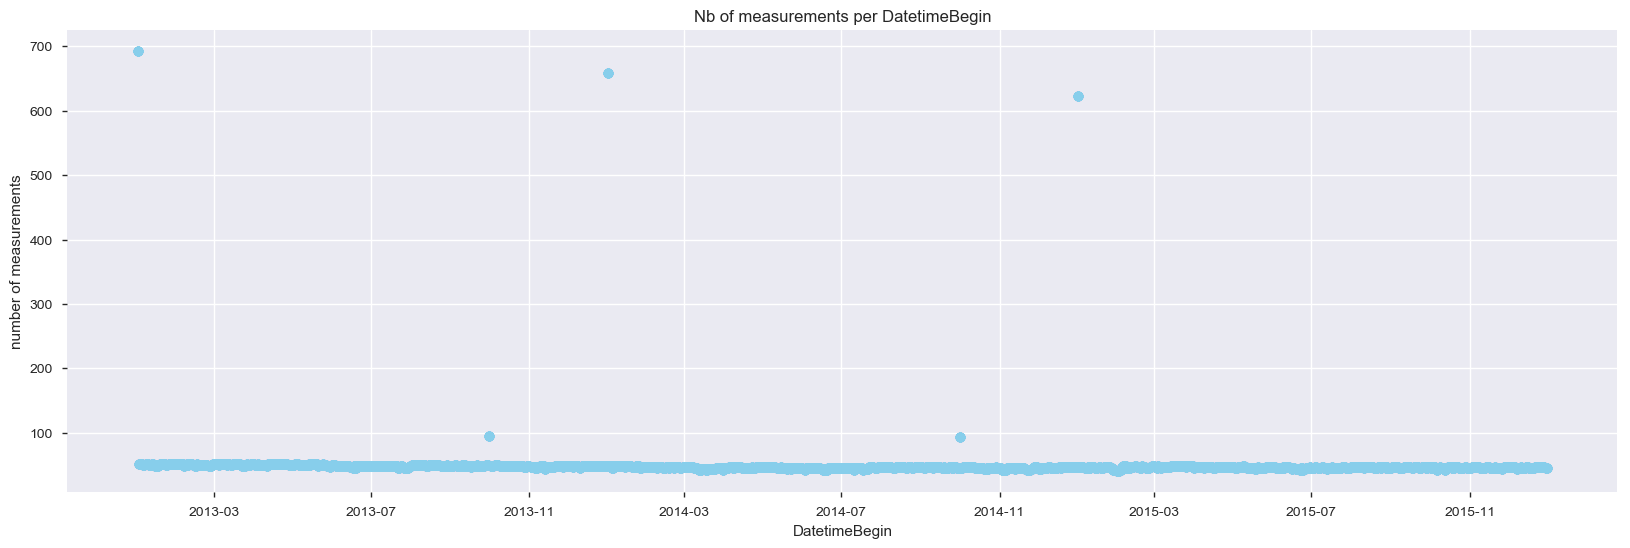

In [4]:
plt.figure(figsize=(20,6))
plt.plot(agg_ts.groupby('DatetimeBegin').count(), 'o', color='skyblue')
plt.title('Nb of measurements per DatetimeBegin')
plt.ylabel('number of measurements')
plt.xlabel('DatetimeBegin')
plt.show()

In [5]:
print(agg_ts.DatetimeBegin.value_counts()[:5])
print(agg_ts.DatetimeEnd.value_counts()[:5])

2013-01-01    693
2014-01-01    659
2015-01-01    623
2013-10-01     95
2014-10-01     93
Name: DatetimeBegin, dtype: int64
2014-01-01    691
2015-01-01    658
2016-01-01    621
2015-04-01     95
2014-04-01     90
Name: DatetimeEnd, dtype: int64


These peaks in number of records are related to the multiple aggregation levels (DataAggregationProcess). The values in DataAggregationProcess on these dates reflect the time period between DatetimeBegin and DatetimeEnd. For example, the 1st of January 2013 is the start date of a one-year measurement period until the 1st of January 2014.

As we are only interested in the daily aggregation level, **filtering out the other aggregation levels** will solve this issue. We can also remove DatetimeEnd for that reason.

#### Missing timesteps on daily aggregation level
As we can see below, **not all SamplingPoints have data for all DatetimeBegin in the three-year period**. These are most likely days where the DataCoverage variable was below 75%. So on these days we do not have sufficient valid measurements. Later in this notebook we will use measurements on prior days to predict the pollution on the current day. 

To have similarly sized timesteps, we will need to insert rows for the missing DatetimeBegin per SamplingPoint. We will **insert the measurement data of the next day with valid data**. 

Secondly, we will **remove the SamplingPoints with too many missing timesteps**. Here we will take an arbitrary number of 1.000 timesteps as the minimum number of required timesteps.

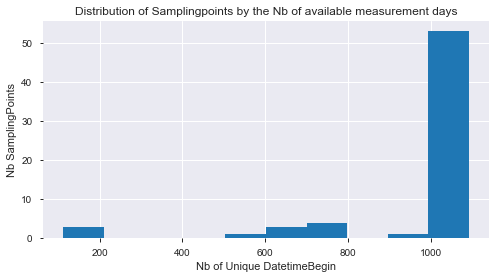

In [44]:
ser_avail_days = agg_ts.groupby('SamplingPoint').nunique()['DatetimeBegin']
plt.figure(figsize=(8,4))
plt.hist(ser_avail_days.sort_values(ascending=False))
plt.ylabel('Nb SamplingPoints')
plt.xlabel('Nb of Unique DatetimeBegin')
plt.title('Distribution of Samplingpoints by the Nb of available measurement days')
plt.show()

## Data Preparation
#### Data Cleaning
Based on the data exploration, we will do the following to clean the data:
* Keeping only records with DataAggregationProcss of P1D
* Removing records with UnitOfAirPollutionLevel of count
* Removing unary variables and other redundant variables
* Removing SamplingPoints which have less than 1000 measurement days

In [45]:
df = agg_ts.loc[agg_ts.DataAggregationProcess=='P1D', :] 
df = df.loc[df.UnitOfAirPollutionLevel!='count', :]
df = df.loc[df.SamplingPoint.isin(ser_avail_days[ser_avail_days.values >= 1000].index), :]
vars_to_drop = ['AirPollutant','AirPollutantCode','Countrycode','Namespace','TimeCoverage','Validity','Verification','AirQualityStation',
               'AirQualityStationEoICode','DataAggregationProcess','UnitOfAirPollutionLevel', 'DatetimeEnd', 'AirQualityNetwork',
               'DataCapture', 'DataCoverage']
df.drop(columns=vars_to_drop, axis='columns', inplace=True)

#### Inserting rows for the missing timesteps
For each SamplingPoint, we will first insert (empty) rows for which we do not have a DatetimeBegin. This can be done by creating a complete multi-index with all SamplingPoints and over the range between the minimum and maximum DatetimeBegin. Then, **reindex** will insert the missing rows but with NaN for the columns. 

Secondly, we use **bfill** and specify to impute the missing values with values of the next row with valid data. The bfill method is applied on a groupby object to limit the backfilling within the rows of each SamplingPoint. That way we do not use values of another SamplingPoint to fill in the missing values.

A samplepoint to test whether this operation worked correctly is *SPO-BETR223_00001_100* for the date *2013-01-29*.

In [46]:
dates = list(pd.period_range(min(df.DatetimeBegin), max(df.DatetimeBegin), freq='D').values)
samplingpoints = list(df.SamplingPoint.unique())

new_idx = []
for sp in samplingpoints:
    for d in dates:
        new_idx.append((sp, np.datetime64(d)))

df.set_index(keys=['SamplingPoint', 'DatetimeBegin'], inplace=True)
df.sort_index(inplace=True)
df = df.reindex(new_idx)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # should contain NaN for the columns

df['AirPollutionLevel'] = df.groupby(level=0).AirPollutionLevel.bfill().fillna(0)
#print(df.loc['SPO-BETR223_00001_100','2013-01-29'])  # NaN are replaced by values of 2013-01-30
print('{} missing values'.format(df.isnull().sum().sum()))

0 missing values


#### Handling multiple time series
Allright, now we have a data set that is cleaned and does not contain any missing values. One aspect that makes this data set particular is that we have data for **multiple samplingpoints**. So we have multiple time series. 

One way to deal with that is to create **dummy variables for the samplingpoints** and use all records to train the model. Another way is to build a **separate model per samplingpoint**. In this notebook we will do the latter. We will however limit the notebook to do that for only one samplingpoint. But the same logic can be applied for every samplingpoint.

In [9]:
df = df.loc['SPO-BETR223_00001_100',:]

#### Split train, test and validation set
We split off a test set in order to evaluate the performance of the model. The test set will not be used during the training phase. 

* train set : data until July 2014
* validation set : 6 months between July 2014 and January 2015
* test set : data of 2015

In [18]:
train = df.query('DatetimeBegin < "2014-07-01"')
valid = df.query('DatetimeBegin >= "2014-07-01" and DatetimeBegin < "2015-01-01"')
test = df.query('DatetimeBegin >= "2015-01-01"')

#### Scaling

In [19]:
# Save column names and indices to use when storing as csv
cols = train.columns
train_idx = train.index
valid_idx = valid.index
test_idx = test.index

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
valid = scaler.transform(valid)
test = scaler.transform(test)

#### Save the processed data sets
That way we don't need to redo the preprocessing every time we rerun the notebook. 

In [20]:
train = pd.DataFrame(train, columns=cols, index=train_idx)
valid = pd.DataFrame(valid, columns=cols, index=valid_idx)
test = pd.DataFrame(test, columns=cols, index=test_idx)

train.to_csv('../data/processed/train.csv')
valid.to_csv('../data/processed/valid.csv')
test.to_csv('../data/processed/test.csv')

## Modeling
First we read in the processed data sets. Secondly we create a function to plot the training and validation loss for the different models we will build.

In [2]:
train = pd.read_csv('../data/processed/train.csv', header=0, index_col=0).values.astype('float32')
valid = pd.read_csv('../data/processed/valid.csv', header=0, index_col=0).values.astype('float32')
test = pd.read_csv('../data/processed/test.csv', header=0, index_col=0).values.astype('float32')

def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

#### Prepare data with the TimeseriesGenerator
The [TimeseriesGenerator of Keras](https://keras.io/preprocessing/sequence/#timeseriesgenerator) helps us building the data in the correct format for modeling.

* **length** : number of timesteps in the generated sequence. Here we want to look back an arbitrary number of *n_lag* timesteps. In reality n_lag could depend on how the predictions will be used. Suppose the Belgian government can take some actions to reduce the SO2 pollution around a samplingpoint (for instance prohibit the entrance of diesel cars in a city for a certain period of time). And suppose the government needs 14 days before the corrective actions can go in effect. Then it would make sense to set n_lag to 14.
* **sampling_rate** : number of timesteps between successive timesteps in the generated sequence. We want to keep all timesteps, so we leave this to the default of 1.
* **stride** : this parameter influences how much the generated sequences will overlap. As we do not have much data, we leave it to the default of 1. This means that two sequences generated after one another overlap with all timesteps except one.
* **batch_size** : number of generated sequences in each batch

In [3]:
n_lag = 14

train_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 5)
valid_data_gen = TimeseriesGenerator(train, train, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)
test_data_gen = TimeseriesGenerator(test, test, length=n_lag, sampling_rate=1, stride=1, batch_size = 1)

#### Recurrent Neural Networks
**Traditional neural networks have no memory**. Consequently they do not take into account previous input when processing the current input. In sequential data sets, like time series, the information of previous time steps is typically relevant for predicting something in the current step. So a **state** about the previous time steps needs to be maintained. 

In our case, the air pollution at time t might be influenced by the air pollution in previous timesteps.  So we need to take that into account. Recurrent Neural Networks or RNNs have an internal loop by which they maintain a state of previous timesteps. This state is then used for the prediction in the current timestep. The state is reset when a new sequence is being processed. For an illustrated guide about RNNs you should definitely read the [article by Michael Nguyen](https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9). 

For our case we use a [SimpleRNN](https://keras.io/layers/recurrent/#simplernn) of the Keras package. We also specify an **EarlyStopping** callback to stop the training when there were 10 epochs without any improvement in the validation loss. The **ModelCheckpoint** allows us to save the weights of the best model. The model architecture still needs to be saved separately.

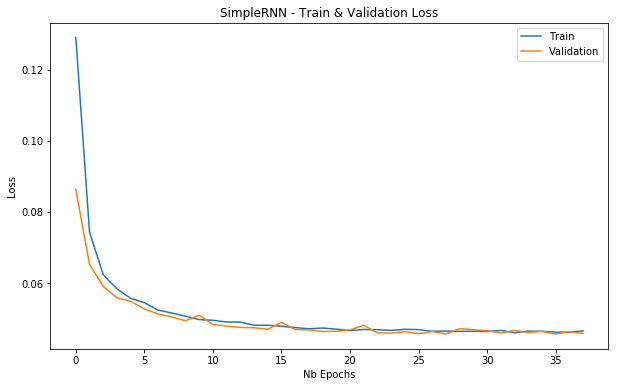

Minimum validation loss of 0.04568587783706564 reached at epoch 27


In [34]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(n_lag, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='../model/simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("../model/simple_rnn.json", "w") as m:
    m.write(simple_rnn.to_json())

simple_rnn_history = simple_rnn.fit_generator(train_data_gen
                                              , epochs=100
                                              , validation_data=valid_data_gen
                                              , verbose=0
                                              , callbacks=[checkpointer, earlystopper])
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

#### Long Short Term Memory Networks
**A RNN has a short memory**. It has difficulty to remember information of many timesteps ago. This occurs when the sequences are very long. In fact it is due to the **vanishing gradient problem**. The gradient are values that update the weights of a neural network. When you have many timesteps in your RNN the gradient for the first layers becomes very tiny. As a result the update of the weights of the first layers is negligable. This means that the RNN is not capable of learning what was in the early layers. 

So we need a way to carry the information of the first layers to later layers. LSTMs are better suited to take into account long-term dependencies. Michael Nguyen wrote an excellent article with a [visual description of LSTMs](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21). 

#### Simple LSTM model

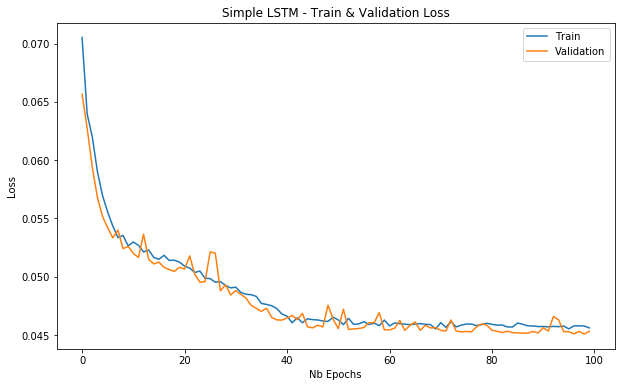

Minimum validation loss of 0.04508350826572291 reached at epoch 98


In [36]:
simple_lstm = Sequential()
simple_lstm.add(LSTM(4, input_shape=(n_lag, 1)))
simple_lstm.add(Dense(1))
simple_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='../model/simple_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("../model/simple_lstm.json", "w") as m:
    m.write(simple_lstm.to_json())

simple_lstm_history = simple_lstm.fit_generator(train_data_gen
                                                , epochs=100
                                                , validation_data=valid_data_gen
                                                , verbose=0
                                                , callbacks=[checkpointer, earlystopper])
plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

#### Stacked LSTM model
In this model we will be stacking multiple LSTM layers. That way the model will learn other abstractions of input data over time. In other words, **representing the input data at different time scales**. 

To do that in Keras, we need to specify the parameter **return_sequences** in the LSTM layer preceding another LSTM layer.

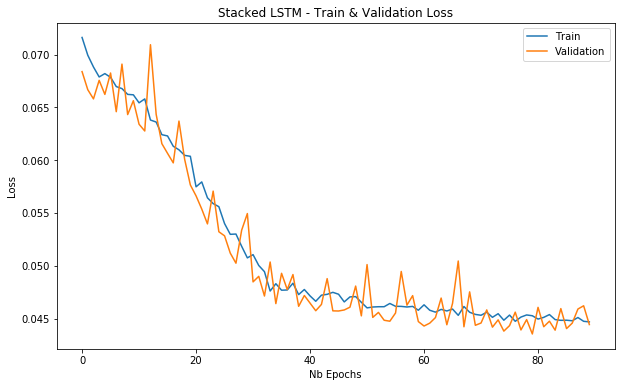

Minimum validation loss of 0.04354060360421322 reached at epoch 79


In [4]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(n_lag, 1), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='../model/stacked_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
with open("../model/stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train_data_gen
                                                  , epochs=100
                                                  , validation_data=valid_data_gen
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

## Evaluating Performance
Based on the minimum validation losses the SimpleRNN seems to outperform the LSTM models, although the metrics are close to each other. With the **evaluate_generator** method we can evaluate the models on the test data (generator). This will give us the loss on the test data. We will first load the model architecture from the JSON files and the best model's weights.

In [5]:
def eval_best_model(model):
    # Load model architecture from JSON
    model_architecture = open('../model/'+model+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights('../model/'+model+'_weights.hdf5')
    # Compile the best model
    best_model.compile(loss='mae', optimizer=RMSprop())
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_data_gen)
    print('Loss on test data for {} : {}'.format(model, perf_best_model))

eval_best_model('simple_rnn')
eval_best_model('simple_lstm')
eval_best_model('stacked_lstm')

Loss on test data for simple_rnn : 0.01638169982337905
Loss on test data for simple_lstm : 0.015934137431135205
Loss on test data for stacked_lstm : 0.015420083056716116
